# Table of Contents
* [Set Global Workflow Variables](#Set-Global-Workflow-Variables)
* [Import Dependencies](#Import-Dependencies)
* [Load Data](#Load-Data)
    * [Main Data](#Main-Data)
    * [Aditional Data](#Aditional-Data)
    * [Filter on Rows with a Sentiment](#Filter-on-Rows-with-a-Sentiment)
* [Exploratory Analysis](#Exploratory-Analysis)
    * [Info and Counts](#Info-and-Counts)
    * [Wordclouds for Bullish and Bearish](#Wordclouds-for-Bullish-and-Bearish)
    * [Exploratory Sentiment Analysis](#Exploratory-Sentiment-Analysis)
* [Data Preprocessing](#Data-Preprocessing)
    * [Data Cleaning, Tokenization, Remove Punctuation, Remove StopWords, Lemmatize](#Data-Cleaning,-Tokenization,-Remove-Punctuation,-Remove-StopWords,-Lemmatize)
* [Model Building](#Model-Building) 
* [Hyper Parameter Tuning using GridSearch](#Hyper-Parameter-Tuning-using-GridSearch) 
* [Model Persistence](#Model-Persistence) 
* [Manual Tests](#Manual-Tests) 

# Set Global Workflow Variables

In [1]:
install_enabled = False
add_external_data_enabled = True
sentimentAnalysis_enabled = True
gridsearch_enabled = False

# Import Dependencies

In [2]:
if (install_enabled == True):
    !pip install -q numpy
    !pip install -q pandas
    !pip install -q nltk
    !pip install -q wordcloud
    !pip install -q sklearn
    !pip install -q xgboost
    !pip install -q dill

In [3]:
import numpy as np
import pandas as pd
import nltk
import sklearn
import re
import os    
from chardet import detect
import string

nltk.download('punkt')
nltk.download('stopwords')
nltk.download('wordnet')
nltk.download('averaged_perceptron_tagger')

pd.set_option('display.max_columns', 5000) 

# import warnings filter
import warnings
# ignore all future warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
warnings.filterwarnings('ignore')

[nltk_data] Downloading package punkt to /home/markus/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to /home/markus/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /home/markus/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /home/markus/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!


# Load Data

## Main Data

In [4]:
# read input file
stw = pd.read_csv('input/Stocktwits.csv')
stw = stw.drop_duplicates()
print(stw.describe())
print(stw.info())

                   id            createdAt    body  symbol stocktwitsSentiment
count          505206               505206  505206  505206              505206
unique         505206               425364  428694      52                   3
top     IBM-193665816  2020-01-30 15:00:02    $SPY     SPY                None
freq                1                   21    2277  121624              286093
<class 'pandas.core.frame.DataFrame'>
Int64Index: 505206 entries, 0 to 505205
Data columns (total 5 columns):
id                     505206 non-null object
createdAt              505206 non-null object
body                   505206 non-null object
symbol                 505206 non-null object
stocktwitsSentiment    505206 non-null object
dtypes: object(5)
memory usage: 23.1+ MB
None


## Add External/Additional Data

In [5]:
if (add_external_data_enabled == True):
    # get file encoding type
    def get_encoding_type(file):
        with open(file, 'rb') as f:
            rawdata = f.read()
        return detect(rawdata)['encoding']

    # add content of additional bullish and bearish files to dataframe

    # Bullish
    add_bullish = []
    file = open('input/bullish.txt', 'r', encoding='Windows-1252') 
    for line in file:
      # remove \n at the end of the
      line = line.strip()
      add_bullish.append(line)
    df_add_bull = pd.DataFrame(add_bullish)
    df_add_bull = df_add_bull.rename(columns={df_add_bull.columns[0]: "body" })
    df_add_bull['stocktwitsSentiment'] = 'Bullish'

    # Bearish
    add_bearish = []
    file = open('input/bearish.txt', 'r', encoding='Windows-1252')
    for line in file:
      # remove \n at the end of the
      line = line.strip()
      add_bearish.append(line)
    df_add_bear = pd.DataFrame(add_bearish)
    df_add_bear = df_add_bear.rename(columns={df_add_bear.columns[0]: "body" })
    df_add_bear['stocktwitsSentiment'] = 'Bearish'

## Filter on Rows with a Sentiment

In [6]:
# only keep id, body and stocktwitssentiment columns
stw = stw.loc[:,['body','stocktwitsSentiment']]

#concat additional dataframes to main dataframe
stw = pd.concat([stw,df_add_bull, df_add_bear],ignore_index=True, sort=True)

# exclude rows without a sentiment
stw = stw[stw['stocktwitsSentiment']!='None']

print('\nstw describe:')
print(stw.describe())

print('\nstw info:')
print(stw.info())

print('\nUnique stocktwitsSentiment values:')
print(stw.stocktwitsSentiment.unique())


stw describe:
          body stocktwitsSentiment
count   220419              220419
unique  192189                   2
top      $TSLA             Bullish
freq      1100              164615

stw info:
<class 'pandas.core.frame.DataFrame'>
Int64Index: 220419 entries, 0 to 506511
Data columns (total 2 columns):
body                   220419 non-null object
stocktwitsSentiment    220419 non-null object
dtypes: object(2)
memory usage: 5.0+ MB
None

Unique stocktwitsSentiment values:
['Bearish' 'Bullish']


# Exploratory Analysis

## Info and Counts

In [7]:
print('Bullish')
print(stw[stw['stocktwitsSentiment']=='Bullish'].info())
print('\n')
print('Bearish')
print(stw[stw['stocktwitsSentiment']=='Bearish'].info())

import matplotlib.pyplot as plt

ax = stw['stocktwitsSentiment'].value_counts(sort=False).plot(kind='barh')
ax.set_xlabel('Number of Samples')
ax.set_ylabel('Sentiment')
plt.show()

Bullish
<class 'pandas.core.frame.DataFrame'>
Int64Index: 164615 entries, 3 to 505911
Data columns (total 2 columns):
body                   164615 non-null object
stocktwitsSentiment    164615 non-null object
dtypes: object(2)
memory usage: 3.8+ MB
None


Bearish
<class 'pandas.core.frame.DataFrame'>
Int64Index: 55804 entries, 0 to 506511
Data columns (total 2 columns):
body                   55804 non-null object
stocktwitsSentiment    55804 non-null object
dtypes: object(2)
memory usage: 1.3+ MB
None


<Figure size 640x480 with 1 Axes>

## Wordclouds for Bullish and Bearish

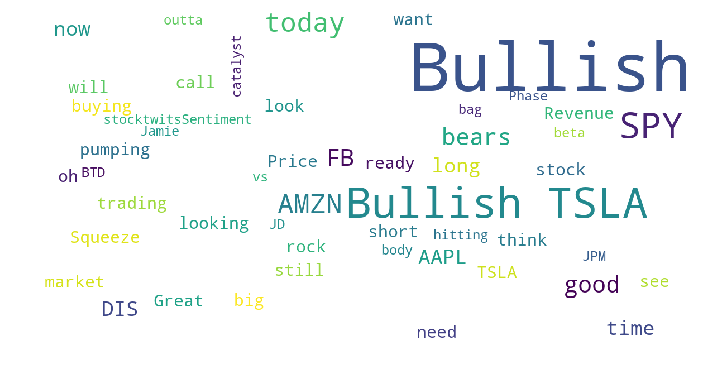

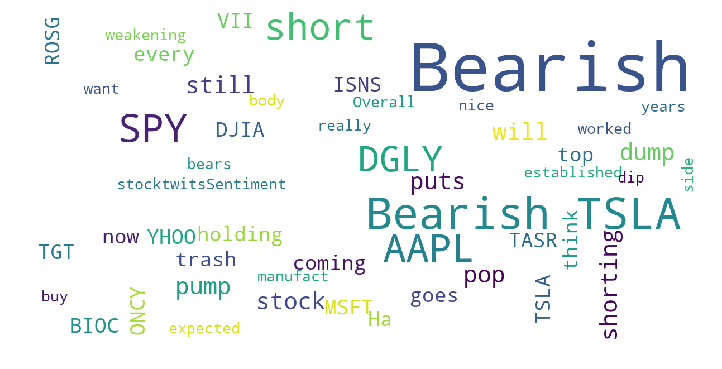

In [8]:
from wordcloud import WordCloud, STOPWORDS
stopwords = set(STOPWORDS)

def show_wordcloud(data, title = None):
    wordcloud = WordCloud(
        background_color='white',
        stopwords=stopwords,
        max_words=50,
        max_font_size=40, 
        scale=3,
        random_state=1
    ).generate(str(data))

    fig = plt.figure(1, figsize=(12, 12))
    plt.axis('off')
    if title: 
        fig.suptitle(title, fontsize=20)
        fig.subplots_adjust(top=2.3)

    plt.imshow(wordcloud)
    plt.show()
    
show_wordcloud(stw[stw['stocktwitsSentiment']=='Bullish'])
show_wordcloud(stw[stw['stocktwitsSentiment']=='Bearish'])

## Exploratory Sentiment Analysis

In [9]:
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer
analyser = SentimentIntensityAnalyzer()

def sentiment_analyzer_scores(sentence):
    score = analyser.polarity_scores(sentence)
    print("{:-<40} {}".format(sentence, str(score)))

if (sentimentAnalysis_enabled == True):
    
    bullish_pos = np.array([])
    bullish_neu = np.array([])
    bullish_neg = np.array([])

    bearish_pos = np.array([])
    bearish_neu = np.array([])
    bearish_neg = np.array([])

    for index, row in stw.iterrows(): 
      scores = analyser.polarity_scores(row['body'])
      if row['stocktwitsSentiment'] == 'Bullish':
        bullish_pos = np.append(bullish_pos, scores['pos'])
        bullish_neu = np.append(bullish_neu, scores['neu'])
        bullish_neg = np.append(bullish_neg, scores['neg'])

      if row['stocktwitsSentiment'] == 'Bearish':
        bearish_pos = np.append(bearish_pos, scores['pos'])
        bearish_neu = np.append(bearish_neu, scores['neu'])
        bearish_neg = np.append(bearish_neg, scores['neg'])

    print('Bullish')
    print('pos: ' + str(np.mean(bullish_pos)))
    print('neu: ' + str(np.mean(bullish_neu)))
    print('neg: ' + str(np.mean(bullish_neg)))
    print('\n')
    print('Bearish')
    print('pos: ' + str(np.mean(bearish_pos)))
    print('neu: ' + str(np.mean(bearish_neu)))
    print('neg: ' + str(np.mean(bearish_neg)))


Bullish
pos: 0.10627439176259758
neu: 0.84476378823315
neg: 0.04891316708683899


Bearish
pos: 0.08228411941796286
neu: 0.828657264712207
neg: 0.0890056268367859


# Data Preprocessing 

## Data Cleaning, Tokenization, Remove Punctuation, Remove StopWords, Lemmatize

In [10]:
from nltk.tokenize import word_tokenize, RegexpTokenizer
from nltk.corpus import stopwords
from nltk import punkt
from nltk.stem import WordNetLemmatizer
from nltk.corpus import wordnet

In [11]:
from sklearn.base import BaseEstimator, TransformerMixin

class MyTextPreprocessor(BaseEstimator, TransformerMixin):  
    """
    custom transformer: applies cleaning and text preprocessing to given input text
    """
    
    def __init__(self):
        self.tokenizer = RegexpTokenizer(r'\w+') 
        self.stop_words = set(stopwords.words('english'))
        self.lemmatizer = WordNetLemmatizer()
        self.blacklist = self.createBlacklist()
    
    def createBlacklist(self):
        """
        blacklist for cashtags/tickers and company names
        """

        wl = pd.read_csv('input/Watchlist.csv')

        symbollist = wl['symbol (S)']
        namelist = wl['name (S)']
        blacklist = []

        blacklist = self.addToBlacklist(symbollist, blacklist)
        blacklist = self.addToBlacklist(namelist, blacklist)

        # manually added entries
        blacklist.append('CMG')
        blacklist.append('BTC')
        blacklist.append('Alphabet')
        blacklist.append('GDX')
        blacklist.append('TSLQ')
        blacklist.append('PCG')
        blacklist.append('QQQ')
        blacklist.append('MNK')
        blacklist.append('ENDP')
        blacklist.append('TEA')
        blacklist.append('AMD')
        blacklist.append('Google')
        blacklist.append('Snap')
        blacklist.append('EOD')
        blacklist.append('EOW')
        blacklist.append('NFLX')
        
        return blacklist

    def addToBlacklist(self, inputlist, blacklist):
        for element in inputlist :
            if(element!='Anheuser-Busch' and element!='Coca-Cola'):
                blacklist.append(element)
                blacklist.append(element.lower())
                blacklist.append(element.upper())
        return blacklist
        
    def clean_text(self, text):
        """
        remove cashtags/tickers, hashtags, mentions, links etc.
        """
        text = re.sub('\s+', ' ', text)
        text = text.strip()

        #remove cashtags/tickers and company names
        for element in self.blacklist:
            pattern = element + '\s'
            text = re.sub(element,'',text)   
        #remove \n and \t
        text = re.sub('\t', '', text)
        text = re.sub('\n', '', text)
        #remove all hastag mentions
        text = re.sub(r'#\S+', '', text)
        # remove @username 
        text = re.sub('@[^\s]+','',text)
        #remove all @ mentions
        text = re.sub(r'@\S+', '', text)
        # remove $, S&amp; 
        # remove \U000...
        text = re.sub('\$|S&amp;|\\U0001f929|\\U0001f960|\\U0001f971','',text)
        # remove all numbers
        text = re.sub('\d+','',text)
        #Remove www.* and https?://*
        text = re.sub('((www\.[^\s]+)|(https?://[^\s]+))',' ',text)
        text = re.sub(r'http\S+', '', text)
        
        text = re.sub('\s+', ' ', text)
        text = text.strip()
        
        return text

    def get_wordnet_pos(self, word):
        """
        Map POS tag to first character lemmatize() accepts
        """
        tag = nltk.pos_tag([word])[0][1][0].upper()
        tag_dict = {"J": wordnet.ADJ,
                    "N": wordnet.NOUN,
                    "V": wordnet.VERB,
                    "R": wordnet.ADV}
        return tag_dict.get(tag, wordnet.NOUN)

    def tok_stop_lemm(self,text):
        """
        tokenize, remove stopwords, lemmatize
        """
        tokenized_text = self.tokenizer.tokenize(text) #tokenize text and remove punctuation
        tokenized_text_wo_stopwods = [w for w in tokenized_text if not w in self.stop_words] #remove stopwords from the list of tokenized words
        lemmatized_output = ' '.join([self.lemmatizer.lemmatize(word, self.get_wordnet_pos(word)) for word in tokenized_text_wo_stopwods]) # lemmatize
        return lemmatized_output

    
    def transform(self, X, **kwargs):
        """
        an abstract method that is used to transform according to what happend in the fit method
        :param X: features - Dataframe
        :param kwargs: free parameters - dictionary
        :return: X: the transformed data - Dataframe
        """
        
        if isinstance(X, pd.Series):
            X = X.apply(self.clean_text)
            X = X.apply(self.tok_stop_lemm)
        elif isinstance(X, pd.DataFrame):
            X = X.apply(self.clean_text, axis = 1)
            X = X.apply(self.tok_stop_lemm, axis = 1)
        elif isinstance(X, list):
            X = map(self.clean_text, X)
            X = map(self.tok_stop_lemm, X)
        else:
            raise AttributeError('Unsupported Datatype found')
        
        return X
    
    def fit(self, X, y=None):
        """
        an abstract method that is used to fit the step and to learn by examples
        :param X: features - Dataframe
        :param y: target vector - Series
        :param kwargs: free parameters - dictionary
        :return: self: the class object - an instance of the transformer - Transformer
        """
        return self

# Model Building

In [12]:
from sklearn.feature_extraction.text import CountVectorizer, TfidfTransformer, TfidfVectorizer
from sklearn.pipeline import Pipeline
#from imblearn.pipeline import Pipeline #use imblearn pipeline instead of sklearn.pipeline due to SMOTE
from sklearn.model_selection import train_test_split, cross_validate

from sklearn.naive_bayes import MultinomialNB
from sklearn.linear_model import LogisticRegression
#from sklearn.ensemble import RandomForestClassifier
#from sklearn.svm import SVC
from xgboost import XGBClassifier #https://www.datacamp.com/community/tutorials/xgboost-in-python

#from imblearn.over_sampling import SMOTE #oversampling due to highly imbalanced data

# Pipeline Building
# https://www.kaggle.com/gautham11/building-a-scikit-learn-classification-pipeline

pipeline_MultinomialNB = [
    # preprocess
    ('preprocess_text', MyTextPreprocessor()),
    #text to vector
    ('vectorizer', CountVectorizer(stop_words=stopwords.words('english'), ngram_range=(1,3))),      
    #classifier
    ('classifier', MultinomialNB(alpha=0.1, class_prior=None, fit_prior=True)), 
]

pipeline_LogisitcRegression = [
    # preprocess
    ('preprocess_text', MyTextPreprocessor()),
    #text to vector
    ('vectorizer', CountVectorizer(stop_words=stopwords.words('english'), ngram_range=(1,3))),
    #('vectorizer', TfidfVectorizer(use_idf = True, stop_words=stopwords.words('english'), ngram_range=(1,3))), 
    #oversampling due to highly imbalanced data
    #('smt', SMOTE()),
    #classifier
    ('classifier', LogisticRegression(class_weight='balanced' , n_jobs=-1)), 
]

pipeline_XGB = [
    # preprocess
    ('preprocess_text', MyTextPreprocessor()),
    #text to vector
    ('vectorizer', CountVectorizer(stop_words=stopwords.words('english'), ngram_range=(1,3))),
    #('vectorizer', TfidfVectorizer(use_idf = False, stop_words=stopwords.words('english'), ngram_range=(1,3))), 
    #oversampling due to highly imbalanced data
    #('smt', SMOTE()),
    #classifier
    ('classifier', XGBClassifier()), #https://xgboost.readthedocs.io/en/latest/parameter.html#general-parameters

]
    
pipeline = Pipeline(pipeline_LogisitcRegression)

print('Pipeline steps:')
print(pipeline.steps)

# Seperate train and test set
# https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.train_test_split.html
# X --> body_preprocessed (Features)
# y --> stocktwitsSentiment (Label)

X_train, X_test, y_train, y_test = train_test_split(stw['body'], stw['stocktwitsSentiment'], test_size=0.2, random_state=123)

print('Shapes train:')
print(X_train.shape)
print(y_train.shape)

print('Shapes test:')
print(X_test.shape)
print(y_test.shape)

# use pipeline to train the model
pipeline.fit(X_train,y_train)

Pipeline steps:
[('preprocess_text', MyTextPreprocessor()), ('vectorizer', CountVectorizer(analyzer='word', binary=False, decode_error='strict',
                dtype=<class 'numpy.int64'>, encoding='utf-8', input='content',
                lowercase=True, max_df=1.0, max_features=None, min_df=1,
                ngram_range=(1, 3), preprocessor=None,
                stop_words=['i', 'me', 'my', 'myself', 'we', 'our', 'ours',
                            'ourselves', 'you', "you're", "you've", "you'll",
                            "you'd", 'your', 'yours', 'yourself', 'yourselves',
                            'he', 'him', 'his', 'himself', 'she', "she's",
                            'her', 'hers', 'herself', 'it', "it's", 'its',
                            'itself', ...],
                strip_accents=None, token_pattern='(?u)\\b\\w\\w+\\b',
                tokenizer=None, vocabulary=None)), ('classifier', LogisticRegression(C=1.0, class_weight='balanced', dual=False,
                   

Pipeline(memory=None,
         steps=[('preprocess_text', MyTextPreprocessor()),
                ('vectorizer',
                 CountVectorizer(analyzer='word', binary=False,
                                 decode_error='strict',
                                 dtype=<class 'numpy.int64'>, encoding='utf-8',
                                 input='content', lowercase=True, max_df=1.0,
                                 max_features=None, min_df=1,
                                 ngram_range=(1, 3), preprocessor=None,
                                 stop_words=['i', 'me', 'my', 'myself', 'we',
                                             'our', 'ours...
                                 strip_accents=None,
                                 token_pattern='(?u)\\b\\w\\w+\\b',
                                 tokenizer=None, vocabulary=None)),
                ('classifier',
                 LogisticRegression(C=1.0, class_weight='balanced', dual=False,
                                    f


Classification Report:
              precision    recall  f1-score   support

     Bearish       0.63      0.68      0.65     10379
     Bullish       0.90      0.88      0.89     33705

    accuracy                           0.83     44084
   macro avg       0.76      0.78      0.77     44084
weighted avg       0.84      0.83      0.83     44084


Confusion Matrix:
[[ 7065  3314]
 [ 4138 29567]]


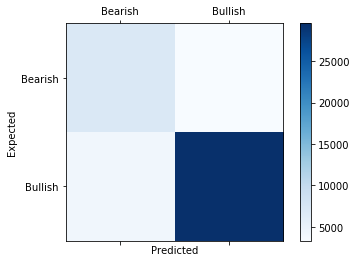

accuracy: 0.8309590781235823
f1_score: 0.8331401278630944


In [17]:
#use pipeline to make predictions on the test set
predictions = pipeline.predict(X_test)

from sklearn.metrics import confusion_matrix, classification_report, accuracy_score, roc_auc_score, f1_score, average_precision_score

#report
print('\nClassification Report:')
print(classification_report(predictions,y_test))

print('\nConfusion Matrix:')
conf_mat = confusion_matrix(predictions,y_test)
print(conf_mat)

labels = ['Bearish', 'Bullish']
fig = plt.figure()
ax = fig.add_subplot(111)
cax = ax.matshow(conf_mat, cmap=plt.cm.Blues)
fig.colorbar(cax)
ax.set_xticklabels([''] + labels)
ax.set_yticklabels([''] + labels)
plt.xlabel('Predicted')
plt.ylabel('Expected')
plt.show()

#accuracy and f1_score
ac_score_calc = str(accuracy_score(predictions,y_test))
f1_score_calc = str(f1_score(predictions,y_test, average = 'weighted'))
print('accuracy: ' + ac_score_calc)
print('f1_score: ' + f1_score_calc)
#print('\\average_precision_score: ' + str(average_precision_score(predictions,y_test)))

# Hyper Parameter Tuning using GridSearch

In [14]:
from sklearn.model_selection import GridSearchCV

param_grid = [
  {
    #Vectorizer
    'vectorizer__ngram_range': [(1, 1), (1, 2), (1, 3)],
    #Classifier
    'classifier' : [MultinomialNB()],
    'classifier__fit_prior': (True, False),
    'classifier__alpha': (1.0, 0.5, 0.2, 0.1, 0.05),
  },
  {
    #Vectorizer
    'vectorizer__ngram_range': [(1, 1), (1, 2), (1, 3)],
    #Classifier
    'classifier' : [LogisticRegression(class_weight='balanced', n_jobs=-1)],
    'classifier__C' : [1.0 , 2.0, 0.5] #Inverse of regularization strength; must be a positive float. Like in support vector machines, smaller values specify stronger regularization.
  },

  # Hyperparameter Tuning with XGBoost
  #https://www.kaggle.com/tilii7/hyperparameter-grid-search-with-xgboost
  {
    #Classifier
    'classifier': [XGBClassifier()],
    'classifier__learning_rate': [0.01],
    'classifier__max_depth': [3, 4, 5, 6, 7, 8], #Maximum depth of a tree. Increasing this value will make the model more complex and more likely to overfit. 0 is only accepted in lossguided growing policy when tree_method is set as hist and it indicates no limit on depth. Beware that XGBoost aggressively consumes memory when training a deep tree.
    'classifier__subsample': [0.5, 0.6, 0.8, 1.0], #Subsample ratio of the training instances. Setting it to 0.5 means that XGBoost would randomly sample half of the training data prior to growing trees. and this will prevent overfitting. Subsampling will occur once in every boosting iteration.
    'classifier__min_split_loss': [0, 0.5, 1, 1.5, 2, 5], #Minimum loss reduction required to make a further partition on a leaf node of the tree. The larger gamma is, the more conservative the algorithm will be.
    'classifier__min_child_weight': [1, 5, 10], #Minimum sum of instance weight (hessian) needed in a child. If the tree partition step results in a leaf node with the sum of instance weight less than min_child_weight, then the building process will give up further partitioning. In linear regression task, this simply corresponds to minimum number of instances needed to be in each node. The larger min_child_weight is, the more conservative the algorithm will be.
  }
]

if(gridsearch_enabled==True):
    # GridSearch Sklearn
    #https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.GridSearchCV.html
    cv_grid = GridSearchCV(pipeline, param_grid = param_grid,  n_jobs=-1, scoring='f1_weighted') #scoring! #https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.GridSearchCV.html

    cv_grid.fit(X_train,y_train)

    print('\nbest_params_')
    print(cv_grid.best_params_)

    y_predict = cv_grid.predict(X_test)

    accuracy = accuracy_score(y_test, y_predict)
    print('\naccuracy of the best classifier after CV is %.3f%%' % (accuracy*100))

    f1 = f1_score(y_test, y_predict, average = 'weighted')
    print('\\f1_score of the best classifier after CV is %.3f%%' % (f1*100))

# Model Persistence

In [15]:
import dill
import datetime
import cloudpickle

#https://www.mikulskibartosz.name/how-to-save-a-machine-learning-model-into-a-file/

toBePersisted = dict({
    'model': pipeline,
    'metadata': {
        'name': '',
        'author': 'Markus Schaeffer',
        'date': datetime.datetime.now(),
        'metrics': {
            'accuracy': ac_score_calc,
            'F1': f1_score_calc
        }
    }
})

#persistance
with open('output/model.pk', 'wb') as f:
    dill.dump(toBePersisted, f)

# Manual Tests

In [16]:
#load
input_file = open('output/model.pk', 'rb')
loaded = dill.load(input_file)
model = loaded['model']

def classify(string):
    print('\n' + string)
    print(model.predict([string]))
    print('Bullish ' + str(model.predict_proba([string])[0][1]))
    print('Bearish ' + str(model.predict_proba([string])[0][0]))

classify('')
classify('I like this stock')
classify('buy this one')
classify('sell that stock')
classify('good profits')
classify('weak earnings')
classify('This one will go down, i hate this stock. Very Bearish')




['Bullish']
Bullish 0.5712553461329614
Bearish 0.42874465386703864

I like this stock
['Bullish']
Bullish 0.6845476945776527
Bearish 0.31545230542234726

buy this one
['Bullish']
Bullish 0.7360461049315117
Bearish 0.2639538950684883

sell that stock
['Bearish']
Bullish 0.45931747343145374
Bearish 0.5406825265685462

good profits
['Bullish']
Bullish 0.6073576966131948
Bearish 0.39264230338680517

weak earnings
['Bearish']
Bullish 0.427347989449373
Bearish 0.572652010550627

This one will go down, i hate this stock. Very Bearish
['Bearish']
Bullish 0.060975776652498995
Bearish 0.939024223347501
